In [1]:
using Plots
gr()


Plots.GRBackend()

In [2]:
# using PyCall
# @pyimport numpy as np

In [6]:
function upwind(u_old::Array{Real}, T_start::Float64, T_end::Float64,
        v::Float64, delta_x::Float64, delta_t::Float64
        )
    num_dof = length(u_old)
    num_tsteps = Int(ceil((T_end - T_start) / delta_t))
    mu = delta_t / delta_x
    u_tmp = copy(u_old)
    u_new = copy(u_old)
    for k in range(1, num_tsteps, step=1)
        for l in range(1, length(u_tmp), step=1)
            if (l==1)
                u_new[l] = u_tmp[l] - mu * v * (u_tmp[l] - u_tmp[(num_dof-1)])
        
            else
                u_new[l] = u_tmp[l] - mu * v * (u_tmp[l] - u_tmp[l-1])
            end                
        end
        u_tmp = copy(u_new)
    end
    return u_new
end
# Define the initial condition
function IC(x)
    if x<-0.4
        y = 0
    elseif (-0.4 <= x) & (x < -0.2)
        y = 1.0-abs(x+0.3) / 0.1
    elseif (-0.2 <= x) & (x< -0.1)
        y = 0
    elseif (-0.1 <= x) & (x<0)
        y = 1
    else
        y = 0
    end
    return y
end
function lax_wendroff(u_old::Array{Real}, T_start::Float64, T_end::Float64,
    v::Float64, delta_x::Float64, delta_t::Float64
    )
    num_dof = length(u_old)
    num_tsteps = Int(ceil((T_end-T_start)/delta_t))
    mu = delta_t / delta_x
    u_tmp = copy(u_old)
    u_new = copy(u_old)
    for k in range(1, num_tsteps, step=1)
        for l in range(1, num_dof-1, step=1)
            if (l==num_dof - 1)
                u_new[l] = u_tmp[l] - 0.5 * mu * v * (u_tmp[1] - u_tmp[l-1]) + 0.5 * (v^2) * (mu^2) *(u_tmp[1]-2*u_tmp[l]+u_tmp[l-1])
            end
            if l==1
                u_new[l] = u_tmp[l] - 0.5 * mu * v * (u_tmp[l+1] - u_tmp[(num_dof - 1)]) + 0.5 * (v^2) * (mu ^2) * (u_tmp[l+1] - 2 * u_tmp[l] + u_tmp[(num_dof - 1)])
            else
                u_new[l] = u_tmp[l] - 0.5 * mu * v * (u_tmp[l+1] - u_tmp[l-1]) + 0.5 * (v^2) * (mu^2) *(u_tmp[l+1]-2*u_tmp[l]+u_tmp[l-1])
            end
        end
        u_tmp = copy(u_new)
    end
    return u_new
end

function IC2(x)
    if x<-0.8
        y = 1.8
    elseif (-0.8 <= x) & (x < -0.3)
        y = 1.4 + 0.4 * cos(2π*(x+0.8))
    elseif (-0.3 <= x) & (x< 0)
        y = 1.0
    else
        y = 1.8
    end
    return y
end


IC2 (generic function with 1 method)

In [4]:
function minmod(duR,duL)
    s = (sign(duR) + sign(duL))/2
    if abs(s) == 1
        return s*min(abs(duR),abs(duL))
    else
        return 0
    end
end 
function minmod_(u_old::Array{Real}, T_start::Float64, T_end::Float64,
    v::Float64, delta_x::Float64, delta_t::Float64
    )
    num_dof = length(u_old)
    num_tsteps = Int(ceil((T_end-T_start)/delta_t))
    mu = delta_t / delta_x
    u_tmp = copy(u_old)
    u_new = copy(u_old)

    u_new_r = copy(u_old)
    u_new_l = copy(u_old)
    for k in range(1, num_tsteps, step=1)
        for l in range(1, num_dof-1, step=1)
            if (l==num_dof - 1)
                u_new_r[l] = u_tmp[1] - u_tmp[l]
                u_new_l[l] = u_tmp[l] - u_tmp[l-1]
                u_new[l] = minmod(u_new_r[l], u_new_l[l]) 
            end
            if l==1
                u_new_r[l] = u_tmp[l+1] - u_tmp[l]
                u_new_l[l] = u_tmp[l] - u_tmp[num_dof-1]
                u_new[l] = minmod(u_new_r[l], u_new_l[l]) 
            else
                u_new_r[l] = u_tmp[l+1] - u_tmp[l]
                u_new_l[l] = u_tmp[l] - u_tmp[l-1]
                u_new[l] = minmod(u_new_r[l], u_new_l[l])
            end
        end
        u_tmp = copy(u_new)
    end
    return u_new
end


minmod_ (generic function with 1 method)

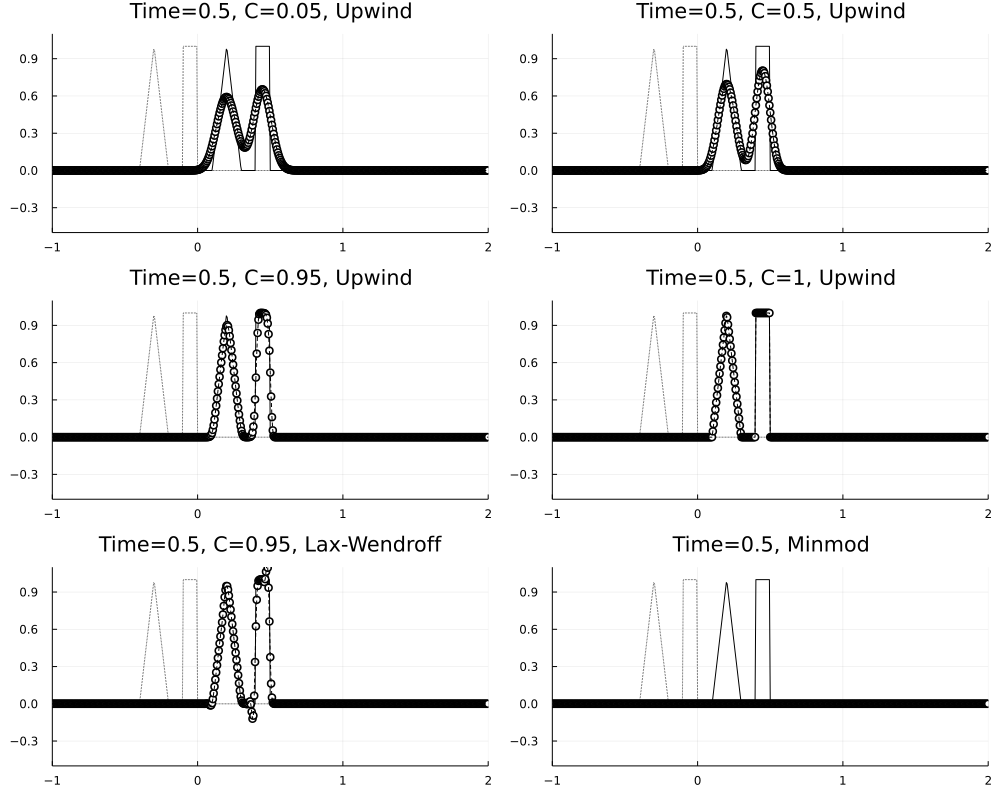

In [5]:
# Test script for the upwind method
T_start = 0.0
T_50 = 0.5
T_end = 1
L = 1
v = 1.0

t = collect(range(-1, 2, length=517))
delta_x = t[2]-t[1]

l = @layout([a b; c d; e f;])

delta_t_0d05 = delta_x * 0.05
p1= plot(t, IC.(t), linecolor=:black, linestyle=:dot, linewidth=:1, label="", title="Time=0.5, C=0.05, Upwind")
p1 = plot!(t, IC.(t .-0.5), linecolor=:black, linestyle=:solid, linewidth=:1, label="")

p1 = scatter!(t, upwind(IC.(t), T_start, T_50, v, delta_x, delta_t_0d05),markershape = :circle, markercolor = :white, markerstrokecolor = :black, label="")
p1 = plot!(t,upwind(IC.(t),T_start, T_50, v, delta_x, delta_t_0d05), linestyle=:dash, linecolor=:black, label="")


delta_t_0d5 = delta_x * 0.5
p2= plot(t, IC.(t), linecolor=:black, linestyle=:dot, linewidth=:1, label="", title="Time=0.5, C=0.5, Upwind")
p2 = plot!(t, IC.(t .-0.5), linecolor=:black, linestyle=:solid, linewidth=:1, label="")

p2 = scatter!(t, upwind(IC.(t), T_start, T_50, v, delta_x, delta_t_0d5),markershape = :circle, markercolor = :white, markerstrokecolor = :black, label="")
p2 = plot!(t,upwind(IC.(t),T_start, T_50, v, delta_x, delta_t_0d5), linestyle=:dash, linecolor=:black, label="")

delta_t_0d95 = delta_x * 0.95
p3 = plot(t, IC.(t), linecolor=:black, linestyle=:dot, linewidth=:1, label="", title="Time=0.5, C=0.95, Upwind")
p3 = plot!(t, IC.(t .-0.5), linecolor=:black, linestyle=:solid, linewidth=:1, label="")

p3 = scatter!(t, upwind(IC.(t), T_start, T_50, v, delta_x, delta_t_0d95),markershape = :circle, markercolor = :white, markerstrokecolor = :black, label="")
p3 = plot!(t,upwind(IC.(t),T_start, T_50, v, delta_x, delta_t_0d95), linestyle=:dash, linecolor=:black, label="")


delta_t = delta_x
p4= plot(t, IC.(t), linecolor=:black, linestyle=:dot, linewidth=:1, label="", title="Time=0.5, C=1, Upwind")
p4 = plot!(t, IC.(t .-0.5), linecolor=:black, linestyle=:solid, linewidth=:1, label="")

p4 = scatter!(t, upwind(IC.(t), T_start, T_50, v, delta_x, delta_t),markershape = :circle, markercolor = :white, markerstrokecolor = :black, label="")
p4 = plot!(t,upwind(IC.(t),T_start, T_50, v, delta_x, delta_t), linestyle=:dash, linecolor=:black, label="")

delta_t_lax = delta_x * 0.95

p5= plot(t, IC.(t), linecolor=:black, linestyle=:dot, linewidth=:1, label="",title="Time=0.5, C=0.95, Lax-Wendroff")
p5 = plot!(t, IC.(t .-0.5), linecolor=:black, linestyle=:solid, linewidth=:1, label="")

p5 = scatter!(t, lax_wendroff(IC.(t), T_start, T_50, v, delta_x, delta_t_lax),markershape = :circle, markercolor = :white, markerstrokecolor = :black, label="")
p5 = plot!(t, lax_wendroff(IC.(t),T_start, T_50, v, delta_x, delta_t_lax), linestyle=:dash, linecolor=:black, label="")


delta_t_lax = delta_x * 0.05
p6= plot(t, IC.(t), linecolor=:black, linestyle=:dot, linewidth=:1, label="", title="Time=0.5, Minmod")
p6 = plot!(t, IC.(t .-0.5), linecolor=:black, linestyle=:solid, linewidth=:1, label="")

p6 = scatter!(t, minmod_(IC.(t), T_start, T_50, v, delta_x, delta_t_lax),markershape = :circle, markercolor = :white, markerstrokecolor = :black, label="")
# p5 = plot!(t, lax_wendroff(IC.(t),T_start, T_50, v, delta_x, delta_t_lax), linestyle=:dash, linecolor=:black, label="")

plot(p1, p2, p3, p4, p5, p6, layout=l,legend=:topright,ylims=(-0.5, 1.1), xlims=(-1, 2), dpi=300)
plot!(size=(1000,800))
# savefig("./hw2.pdf")


In [ ]:
foo=f;
for is=1:2 %two steps per timestep
    fo=f;
    for i=2:n-1
        bot=(fo(i)-fo(i-1));
        top=(fo(i+1)-fo(i));
        r=top*bot/(bot^2+0.00001);
        psi=max([0, min([r,1])]); % minmod
        fh(i)=fo(i)+0.5*psi*(fo(i)-fo(i-1));
    end
    bot=(fo(1)-fo(n-1));
    top=(fo(2)-fo(1));
    r=top*bot/(bot^2+0.00001);
    psi=max([0, min([r,1])]); % minmod
    fh(1)=fo(1)+0.5*psi*(fo(1)-fo(n-1));
    fh(n)=fh(1);
    for i=2:n-1
        f(i)=fo(i)-Co*(fh(i)-fh(i-1) );
    end
    f(1)=fo(1)-Co*(fh(1)-fh(n-1) );
    f(n)=f(1);
end
for i=1:n
    f(i)=0.5*(f(i)+foo(i));
end

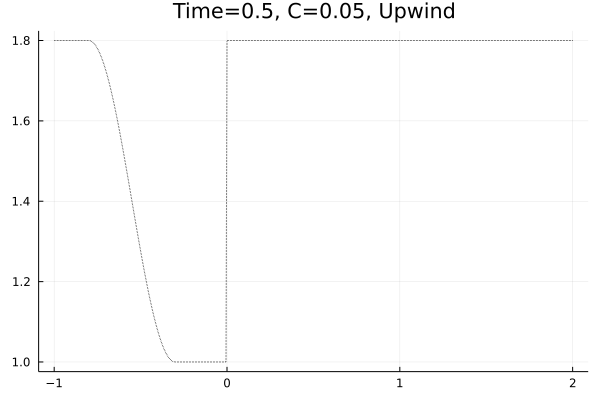

In [8]:
# Test script for the upwind method
T_start = 0.0
T_50 = 0.5
T_end = 1
L = 1
v = 1.0

t = collect(range(-1, 2, length=517))
delta_x = t[2]-t[1]

plot(t, IC2.(t), linecolor=:black, linestyle=:dot, linewidth=:1, label="", title="Time=0.5, C=0.05, Upwind")
# plot!(t, IC2.(t .-0.5), linecolor=:black, linestyle=:solid, linewidth=:1, label="")

# p1 = scatter!(t, upwind(IC.(t), T_start, T_50, v, delta_x, delta_t_0d05),markershape = :circle, markercolor = :white, markerstrokecolor = :black, label="")
# p1 = plot!(t,upwind(IC.(t),T_start, T_50, v, delta_x, delta_t_0d05), linestyle=:dash, linecolor=:black, label="")
